In [1]:
import itertools
from collections import namedtuple

import seaborn as sns
import json
import numpy as np
import pandas as pd

from bounds.bound_utils import Error
from expe_lib import unpickle_bound, PROBLEMS, compute_errors, compute_errors_from_values
from expe_lib import load_result_and_bounds

try:
    snakemake.input
except:
    snakemake = type('', (), {})()
    snakemake.input = {
        "bounds": "output/bounds/lb/robust_flat/toy_1/6.json, output/bounds/lb/robust_line_left/toy_1/6.json, output/bounds/lb/robust_line_right/toy_1/6.json, output/bounds/lb/robust_xyflat/toy_1/6.json, output/bounds/lb/lagrangian_flat/toy_1/6.json, output/bounds/lb/lagrangian_quadratic/toy_1/6.json, output/bounds/lb/robust_concave_envelope/toy_1/6.json, output/bounds/lb/robust_fixed_slope/toy_1/6.json".replace(" ", "").split(","),
        "truth": "output/truth/toy_1/100.npz"
    }
    snakemake.wildcards = {"problem": "toy_1", "n": 6, "type": "lb"}
    snakemake.output = "output/pareto/toy_1/lb_6.png"

(949004,)
(2025829, 1)


In [2]:

data = [load_result_and_bounds(f) for f in snakemake.input["bounds"]]
truth = np.load(snakemake.input["truth"])["arr_0"]
problem = PROBLEMS[snakemake.wildcards["problem"]]()

def simplify(entry):
    space = np.linspace(*problem.range, truth.shape[0])
    bounds = [x["bound"](space) if x["bound"] is not None else Error()(space) for x in entry["bounds"]]
    
    if entry["bound_type"] == "lb":
        bounds = np.max(np.nan_to_num(bounds, nan=-np.inf), axis=0)
    else:
        bounds = np.min(np.nan_to_num(bounds, nan=np.inf), axis=0)
    return bounds, entry["timing - fixed costs"] + entry["timing"]

data = {x["name"]: simplify(x) for x in data}

#for result in data.values():
#    result["error"] = compute_errors(problem, result, truth)

In [3]:
Experiment = namedtuple("Experiment", ["names", "values", "timing", "error"])

def merge_bounds(bounds):
    if snakemake.wildcards["type"] == "lb":
        out = np.max([data[x][0] for x in bounds], axis=0)
    else:
        out = np.min([data[x][0] for x in bounds], axis=0)
        
    timing = sum([data[x][1] for x in bounds])
    return Experiment(bounds, out, timing, compute_errors_from_values(out, truth))

todo = []
for n in range(1, len(data)+1):
    todo += list(itertools.combinations(data, n))

todo = {
    x: merge_bounds(x)
    for x in todo
}

In [4]:
df = pd.DataFrame([{"names": x.names, "error": x.error.rel, "timing": x.timing} for x in todo.values() if x.error.availability == 1.0])
df

,names,error,timing
0,"(robust_flat,)",0.800276,0.023367
1,"(robust_line_left,)",12.138969,0.042438
2,"(robust_line_right,)",3.329829,0.039115
3,"(robust_xyflat,)",0.618542,0.031270
4,"(lagrangian_flat,)",3.605749,0.052680
...,...,...,...
249,"(robust_flat, robust_line_left, robust_line_ri...",0.396962,0.355934
250,"(robust_flat, robust_line_left, robust_xyflat,...",0.396962,0.348089
251,"(robust_flat, robust_line_right, robust_xyflat...",0.396962,0.344765
252,"(robust_line_left, robust_line_right, robust_x...",0.396962,0.363836


(0.3, 1.0)

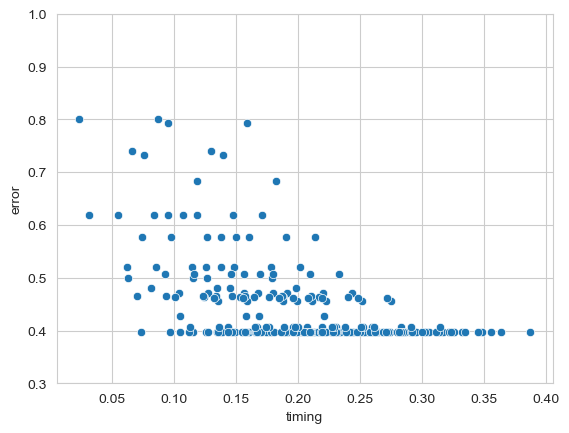

In [5]:
fig = sns.scatterplot(df, y="error", x="timing")
fig.set_ylim(0.3, 1)

In [6]:
[x.names for x in todo.values() if x.error.availability < 1]

[('lagrangian_quadratic',)]

In [7]:
def compute_non_dominated():
    for x in todo.values():
        ok = True
        for y in todo.values():
            if x != y:
                if y.error.abs - x.error.abs < 1e-6 and y.timing < x.timing:
                    ok = False
                    break
        if ok:
            yield x

todo_nd = list(compute_non_dominated())
df_nd = pd.DataFrame([{"names": x.names, "error": x.error.abs, "timing": x.timing} for x in todo_nd if x.error.availability == 1.0])
df_nd

,names,error,timing
0,"(robust_flat,)",0.640221,0.023367
1,"(robust_xyflat,)",0.494833,0.031270
2,"(robust_concave_envelope,)",0.317570,0.073052
3,"(robust_fixed_slope,)",0.415646,0.061602
4,"(robust_flat, robust_line_right)",0.399863,0.062482
5,"(robust_line_right, robust_xyflat)",0.371669,0.070385


FileNotFoundError: [Errno 2] No such file or directory: 'output/pareto/toy_1/lb_6.png'

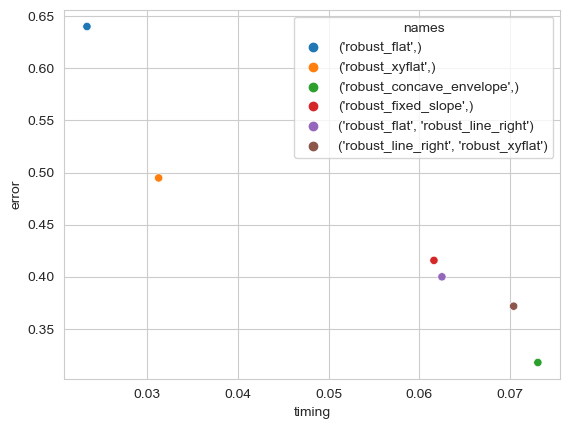

In [10]:
fig = sns.scatterplot(df_nd, y="error", x="timing", hue="names")
fig.get_figure().savefig(str(snakemake.output))
fig